# Problem Understanding
    1. you will be required to explore, segment, and cluster the neighborhoods in the city of Toronto based on the postalcode and borough information
    2. unlike New York, the neighborhood data is not readily available on the internet
    3. the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto
    4. You will be required to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas  dataframe so that it is in a structured format like the New York dataset
    5. you can replicate the analysis that we did to the New York City dataset to explore and cluster the neighborhoods in the city of Toronto
    6. submission will be a link to your Jupyter Notebook on your Github repository

# Analytic Approach
    1. Visualization
    2. Clustering

# Data Requirements
1. postal code
2. borough
3. places in the neigborhood
3. latitude and longitude

# Data Collection
1. Webscraping articles
2. foursquare API

# Data Understanding
1. EDA
2. Geo Visualization
3. Finding Cluster

# Data Preparation
1. clean missing value
2. clean duplicate
3. fix to proper data format
4. fix data consistency

# Modeling
## Unsupervised : Clustering

Algorithm to experiment :
1. K-Means

# Evaluation
1. Inertia
2. cluster label evaluation against problem

# Deployment
1. Spatial Visualization
2. model object

# Working Section

### Credentials

In [1]:
#credentials
CLIENT_ID = '3DDRIZ0SKFRREIRMDBN30EFPHWBZ1ROU3CHHK4E3PMSXA0W3'
CLIENT_SECRET = 'ZLSBPJSRJKAMGSSK1IYBD1HMP02DKDYCZHAJDK0PZDDKHU3J'
VERSION = '20210606'

### Required library and toolkits

In [2]:
# import and install required tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import json
import requests
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

!pip install folium
!pip install selenium
!pip install geopy
from geopy.geocoders import Nominatim
import folium
import selenium
from selenium import webdriver
import time
import sys

pd.set_option('max_rows',None)

!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
print('\n')
print('\n')
print('Folium ready to use')
print('selenium ready to use')
print('geopy ready to use')

     |████████████████████████████████| 911kB 32.0MB/s 
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ 

In [81]:
import sys
#increasing recurrsion limit
print(sys.getrecursionlimit())
sys.setrecursionlimit(10**5)
print(sys.getrecursionlimit())

10000
100000


### Webscraping for data collection

In [4]:
def scrape(url):
    #parameter for running selenium in google colabs
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.79 Safari/537.36')
    #webdriver get request url
    driver = webdriver.Chrome('chromedriver',options=chrome_options)
    driver.get(url)
    #simulate scroll down
    temp_find = driver.find_elements_by_tag_name('div')
    driver.execute_script("return arguments[0].scrollIntoView();", temp_find[-1])
    time.sleep(3)
    #source code parsing
    soup = BeautifulSoup(driver.page_source,'lxml')
    return soup

In [5]:
def data_version1(soup_source):
    bg_nbh_row = soup_source.find_all('table',class_="wikitable sortable jquery-tablesorter")[1].find_all('tr')
    cdn = []
    city_nbh = []
    borough = []
    nbh_covered= []
    for i in bg_nbh_row[1:]:
        cdn.append(i.text.split('\n')[1])
        city_nbh.append(i.text.split('\n')[3])
        borough.append(i.text.split('\n')[5])
        nbh_covered.append(i.text.split('\n')[7])

    #data retrieved v1
    df = pd.DataFrame({'City_Neighborhood':city_nbh,
                       'Borough':borough,
                       'Neighborhood_Covered':nbh_covered})
    return df

In [6]:
def data_version2(soup_source):
    pos_tbl = soup_source.find('table')
    pos_row_tbl = pos_tbl.find_all('td')
    scraped_data = []
    for i in pos_row_tbl:
        data = {}
        if i.span.text == 'Not assigned':
            pass
        else:
            transformed = ((((i.span.text).split('(')[1]).strip(')')).replace(' /',',').replace(')',' ')).strip(' ')
            data['Neighborhood'] = transformed
            data['Postal_Code'] = i.b.text
            data['Borough'] = i.span.text.split('(')[0]
            scraped_data.append(data)
    #data retrieved v2
    df2 = pd.DataFrame(scraped_data)
    df2['Borough'] = df2['Borough'].replace({'MississaugaCanada Post Gateway Processing Centre':'Mississauga',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto',
                                             'East YorkEast Toronto':'East York',
                                             'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto',
                                             'EtobicokeNorthwest':'Etobicoke Northwest'})
    #get latitude longitude using nominatim
    lat = []
    long = []
    geolocator = Nominatim(user_agent='kevinelfri@ymail.com')
    for i in df2['Neighborhood']:
        nbh = i.split(',')[0]
        loc = geolocator.geocode('{}, Ontario, Canada'.format(nbh),timeout=10)
        if loc == None:
            lat.append(np.nan)
            long.append(np.nan)
        else:
            lat.append(loc.latitude)
            long.append(loc.longitude)
            
    df2['Latitude'] = lat
    df2['Longitude'] = long
    #realibrating, reformating, and data cleaning
    df2.loc[df2['Neighborhood']=='Ontario Provincial Government'] = ["Queen's Park","M7A","North York","43.662652","-79.390034"]
    df2.loc[df2['Neighborhood']=='Caledonia-Fairbanks','Neighborhood'] = "Caledonia and Fairbanks"
    df2.loc[df2['Neighborhood']=='Caledonia and Fairbanks',['Latitude','Longitude']] = ["43.687717","-79.450228"]
    df2.loc[df2['Neighborhood']=='Enclave of L4W',['Neighborhood','Latitude','Longitude']] = ["Rockwood Village","43.636913","-79.616343"]
    df2.loc[df2['Neighborhood']=='Enclave of M4L',['Neighborhood','Latitude','Longitude']] = ["Leslieville","43.663092","-79.321078"]
    df2.loc[df2['Neighborhood']=='Enclave of M5E','Neighborhood'] = ["South Core"]
    df2.loc[df2['Neighborhood']=='Islington Avenue',['Latitude','Longitude']] = [43.651094, -79.534877]
    df2.loc[df2['Postal_Code']=='M6M',['Neighborhood','Latitude','Longitude']] = ["Silverthorn, MT Dennis, Greenhills, Amesbury, Brookhaven",43.651094, -79.534877]
    df2.loc[df2['Postal_Code']=='M2J',['Latitude','Longitude']] = [43.781076, -79.346486]
    df2.loc[df2['Postal_Code']=='M5W',['Latitude','Longitude']] = [43.646481, -79.374930]
    df2['Latitude'] = df2['Latitude'].astype('float64')
    df2['Longitude'] = df2['Longitude'].astype('float64')
    return df2

### Render Toronto Map and the neighbors from dataframe 

In [7]:
def toronto_neighborhood():
    toronto_query = 'Toronto, ON, CA'
    geolocator = Nominatim(user_agent='kevinelfri@ymail.com')
    toronto_loc = geolocator.geocode(toronto_query)
    toronto_map = folium.Map(location=[toronto_loc.latitude,toronto_loc.longitude],zoom_start=10)
    #data from version 2
    for lat,lon,nei,bor in zip(df2['Latitude'],df2['Longitude'],df2['Neighborhood'],df2['Borough']):
        label = "{}, {}, Ontario, Canada".format(nei,bor)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='#f4f73b',
            fill_opacity=0.5,
            parse_html=False).add_to(toronto_map)
    return toronto_map

### Foursquare Request for Venues 

In [8]:
def parkwood_venues():
    recommended_ven_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&radius=500&limit=100&v={}'.format(CLIENT_ID,
                                                                                                                                                CLIENT_SECRET,
                                                                                                                                                df2['Latitude'][0],
                                                                                                                                                df2['Longitude'][0],
                                                                                                                                                VERSION)
    rec_ven_result = requests.get(recommended_ven_url).json()['response']['groups'][0]['items']
    parkwoods_venues_df = pd.json_normalize(rec_ven_result)

    #extract venue category
    def cat_name(x):
        try:
            cat = x['categories']
        except:
            cat = x['venue.categories']
        if len(cat) == 0:
            return None
        else:
            return cat[0]['name']
    #pick only relevan columns from response dataframe
    relevant = ['venue.name','venue.location.lat','venue.location.lng','venue.categories']
    parkwoods = parkwoods_venues_df[relevant].copy()

    #filter only relevan information for project
    parkwoods['venue.categories'] = parkwoods.apply(cat_name,axis=1)
    parkwoods.columns = [x.split('.')[-1] for x in parkwoods.columns]

    return parkwoods

# all neighborhood recommended venues 

In [9]:
def rec_venues_df(nbh,latitude,longitude):
    venues_list=[]
    for ne,la,lo in zip(nbh,latitude,longitude):

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&radius=500&limit=100&v={}'.format(CLIENT_ID,CLIENT_SECRET,la,lo,VERSION)
        result = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            ne, 
            la, 
            lo, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in result])
    dataframe = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    dataframe.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return (dataframe)

#One hot encoded and aggregated format

In [10]:
def toronto_OHE():
    toronto_ohe = pd.get_dummies(toronto_venues['Venue Category'])
    toronto_ohe['Neighborhood'] = toronto_venues['Neighborhood']
    column_order = ["Neighborhood"]+[col for col in toronto_ohe.columns[toronto_ohe.columns != "Neighborhood"]]
    toronto_ohe = toronto_ohe[column_order]
    #multi column named Neighborhood in the data frame, causing error
    aggregated_toronto = toronto_ohe.groupby(['Neighborhood']).sum().reset_index()
    return toronto_ohe,aggregated_toronto

# n common venues in neighborhood

In [11]:
def get_common_venues(locations,n_common):
    for i in locations:
        temp = aggregated_toronto[aggregated_toronto['Neighborhood'] == i].T.reset_index()
        temp = temp.iloc[1:]
        temp.columns = ['Venue','Frequency']
        temp = temp.sort_values('Frequency',ascending=False).reset_index(drop=True).head(n_common)

        header = pd.DataFrame(columns=[f'Location: {i}',' '])

        display(header)
        display(temp)
        print('\n')

# common venues dataframe format

In [12]:
def return_most_common(idx, n_common):
    columns = idx.iloc[1:]
    columns = columns.sort_values(ascending=False)
    return columns.index.values[:n_common]

def neighborhood_common_venues(n_common):
    suffix = ['st','nd','rd']
    columns = ['Neighborhood']
    for i in range(n_common):
        try:
            columns.append('{}{} Most Common'.format(i+1,suffix[i]))
        except:
            columns.append('{}th Most Common'.format(i+1))
    dataframe = pd.DataFrame(columns=columns)
    #aggregated data depend on variable name
    dataframe['Neighborhood'] = aggregated_toronto_ohe['Neighborhood']
    for i in range(len(aggregated_toronto_ohe)):
        dataframe.iloc[i,1:] = return_most_common(aggregated_toronto_ohe.iloc[i,:],n_common)
    return dataframe


# clustering 

In [13]:
def find_best_cluster(data,n_cluster):
    inertia = []
    for i in range(n_cluster):
        kmeans = KMeans(n_clusters=i+1,algorithm='elkan')
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    
    plt.plot(range(1,n_cluster+1),inertia)
    plt.grid()
    plt.xlabel('N Cluster')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()
    return inertia

# data instancing

In [14]:
#url to be scraped
bg_nbh_url ='https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Toronto'
postal_url ='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [15]:
#source code from url
soup_source1 = scrape(bg_nbh_url)
soup_source2 = scrape(postal_url)

# base dataframe version
df1 = data_version1(soup_source1)
df2 = data_version2(soup_source2)

# toronto and ts neighborhood map
#toronto_neighborhood()

# one neighborhood venues dataframe
parkwood_venue = parkwood_venues()

#one coordinate not showing any result, 102 of 103 results given
#toronto neighborhood venues recommendation dataframe
toronto_venues = rec_venues_df(df2['Neighborhood'],df2['Latitude'],df2['Longitude'])

#one hot encoded and aggregated (sum) format dataframe
toronto_ohe,aggregated_toronto_ohe = toronto_OHE()

#n common venues 
#get_common_venues(aggregated_toronto['Neighborhood'],5)

#n common venues dataframe
neighborhood_common_venues_df = neighborhood_common_venues(10)

#find best cluster
toronto_clustering = aggregated_toronto_ohe.drop('Neighborhood',1)
#find_best_cluster(toronto_clustering,12)
#best cluster = 5

#Clustering Common Venues

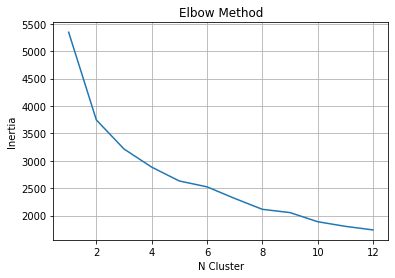

[5346.475247524756,
 3746.4959677419356,
 3215.511470588235,
 2884.7256249999996,
 2631.49860446571,
 2525.0910569105695,
 2313.5034226190473,
 2114.632513661202,
 2054.800359874044,
 1888.5517345399696,
 1803.7843137254902,
 1738.7367781155015]

In [16]:
find_best_cluster(toronto_clustering,12)
#best cluster = 5

In [29]:
#clustering
kmeans = KMeans(n_clusters=5,algorithm='elkan',random_state=1)
toronto_Clabels = kmeans.fit_predict(toronto_clustering)
#assigning cluster label to dataframe
neighborhood_common_venues_df['Cluster label'] = toronto_Clabels

#merging toronto neighborhood data and common venues data
toronto_concat = pd.merge(neighborhood_common_venues_df,df2,how='left',on='Neighborhood')
#feature selection, rearraging column order
toronto_concat.drop('Postal_Code',inplace=True,axis=1)
column_order=['Neighborhood']+list(toronto_concat.columns[12:])+ ['Cluster label'] +list(toronto_concat.columns[1:11])
#should not run more than 1
toronto_concat = toronto_concat[column_order]

#export DF
#toronto_concat.to_csv('Toronto neighborhood cluster and common venues.csv',index=False,index_label=False)

In [58]:
def toronto_cluster_map(kclusters= 5):
    toronto_query = 'Toronto, ON, CA'
    geolocator = Nominatim(user_agent='kevinelfri@ymail.com')
    toronto_loc = geolocator.geocode(toronto_query)
    toronto_map = folium.Map(location=[toronto_loc.latitude,toronto_loc.longitude],zoom_start=11)
    

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    for lat, lon, poi, cluster in zip(toronto_concat['Latitude'], toronto_concat['Longitude'], toronto_concat['Neighborhood'], toronto_concat['Cluster label']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(toronto_map)
       
    return toronto_map

In [59]:
toronto_cluster_map()

#Function Definition

In [20]:
#all of dataframe can be inspected
#uncomment one to inspect

#df1.head() #data version 1
#df2.head() #data version 2
#parkwood_venue.head() #sample neighborhood venues
#toronto_venues.head() #venues around toronto neighborhood
#toronto_ohe.head() #one hot encoded venues categories
#aggregated_toronto_ohe.head() #aggregated SUM from toronto OHE
#neighborhood_common_venues_df.head() # most common venues categories in neighborhood

#other function possibilities

#toronto_neighborhood() #toronto map
#find_best_cluster(toronto_clustering,12) #search best cluster using elbow method
#get_common_venues(aggregated_toronto['Neighborhood'],5) #common venues
#toronto_concat #final dataframe
#toronto_cluster_map() #final cluster map

In [21]:
df1.head() #data version 1

,City_Neighborhood,Borough,Neighborhood_Covered
0,Agincourt North,Scarborough,Agincourt and Brimwood
1,Agincourt South-Malvern West,Scarborough,Agincourt and Malvern
2,Alderwood,Etobicoke,Alderwood
3,Annex,Old City of Toronto,The Annex and Seaton Village
4,Banbury-Don Mills,North York,Don Mills


In [22]:
df2.head() #data version 2

,Neighborhood,Postal_Code,Borough,Latitude,Longitude
0,Parkwoods,M3A,North York,43.758800,-79.320197
1,Victoria Village,M4A,North York,43.732658,-79.311189
2,"Regent Park, Harbourfront",M5A,Downtown Toronto,43.660706,-79.360457
3,"Lawrence Manor, Lawrence Heights",M6A,North York,43.722079,-79.437507
4,Queen's Park,M7A,North York,43.662652,-79.390034


In [24]:
parkwood_venue.head() #sample neighborhood venues

,name,lat,lng,categories
0,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Petro-Canada,43.757950,-79.315187,Gas Station
2,TD Canada Trust,43.757440,-79.314838,Bank
3,LCBO,43.757774,-79.314257,Liquor Store
4,Pizza Pizza,43.760231,-79.325666,Pizza Place


In [25]:
toronto_venues.head() #venues around toronto neighborhood

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.7588,-79.320197,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.7588,-79.320197,Petro-Canada,43.757950,-79.315187,Gas Station
2,Parkwoods,43.7588,-79.320197,TD Canada Trust,43.757440,-79.314838,Bank
3,Parkwoods,43.7588,-79.320197,LCBO,43.757774,-79.314257,Liquor Store
4,Parkwoods,43.7588,-79.320197,Pizza Pizza,43.760231,-79.325666,Pizza Place


In [26]:
toronto_ohe.head() #one hot encoded venues categories

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,...,Soccer Stadium,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tour Provider,Toy / Game Store,Trail,Train,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
aggregated_toronto_ohe.head() #aggregated SUM from toronto OHE

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,...,Soccer Stadium,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tour Provider,Toy / Game Store,Trail,Train,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bayview Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Bedford Park, Lawrence Manor East",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
neighborhood_common_venues_df.head() # most common venues categories in neighborhood

,Neighborhood,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common,Cluster label
0,Agincourt,Hong Kong Restaurant,Asian Restaurant,Food Court,Korean Restaurant,Vietnamese Restaurant,Chinese Restaurant,Coffee Shop,Electronics Store,Train Station,Escape Room,1
1,"Alderwood, Long Branch",Pizza Place,Pharmacy,Pub,Sandwich Place,Playground,Coffee Shop,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,1
2,"Bathurst Manor, Wilson Heights, Downsview North",Baseball Field,Playground,Park,Convenience Store,Yoga Studio,Event Space,Donut Shop,Egyptian Restaurant,Electronics Store,Escape Room,1
3,Bayview Village,Bank,Fast Food Restaurant,Metro Station,Persian Restaurant,Breakfast Spot,Fish Market,Outdoor Supply Store,Pizza Place,Gas Station,Sporting Goods Shop,1
4,"Bedford Park, Lawrence Manor East",Gym / Fitness Center,Construction & Landscaping,Yoga Studio,Event Space,Donut Shop,Egyptian Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Falafel Restaurant,1


In [33]:
toronto_concat.head() #final dataframe

,Neighborhood,Borough,Latitude,Longitude,Cluster label,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
0,Agincourt,Scarborough,43.785353,-79.278549,1,Hong Kong Restaurant,Asian Restaurant,Food Court,Korean Restaurant,Vietnamese Restaurant,Chinese Restaurant,Coffee Shop,Electronics Store,Train Station,Escape Room
1,"Alderwood, Long Branch",Etobicoke,43.601717,-79.545232,1,Pizza Place,Pharmacy,Pub,Sandwich Place,Playground,Coffee Shop,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",North York,43.763893,-79.456367,1,Baseball Field,Playground,Park,Convenience Store,Yoga Studio,Event Space,Donut Shop,Egyptian Restaurant,Electronics Store,Escape Room
3,Bayview Village,North York,43.769197,-79.376662,1,Bank,Fast Food Restaurant,Metro Station,Persian Restaurant,Breakfast Spot,Fish Market,Outdoor Supply Store,Pizza Place,Gas Station,Sporting Goods Shop
4,"Bedford Park, Lawrence Manor East",North York,43.737388,-79.410925,1,Gym / Fitness Center,Construction & Landscaping,Yoga Studio,Event Space,Donut Shop,Egyptian Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Falafel Restaurant


In [56]:
toronto_concat.loc[toronto_concat['Neighborhood'] == toronto_concat['Neighborhood'].duplicated(),:]

,Neighborhood,Borough,Latitude,Longitude,Cluster label,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common


In [57]:
toronto_concat.iloc[20:24]

,Neighborhood,Borough,Latitude,Longitude,Cluster label,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
20,Don Mills North,North York,43.775347,-79.345944,0,Clothing Store,Coffee Shop,Japanese Restaurant,Fast Food Restaurant,Shoe Store,Bank,Cosmetics Shop,Restaurant,Sandwich Place,Convenience Store
21,Don Mills South,North York,43.775347,-79.345944,0,Clothing Store,Coffee Shop,Japanese Restaurant,Fast Food Restaurant,Shoe Store,Bank,Cosmetics Shop,Restaurant,Sandwich Place,Convenience Store
22,"Dorset Park, Wexford Heights, Scarborough Town...",Scarborough,43.752847,-79.282067,1,Furniture / Home Store,Beer Store,Wings Joint,Accessories Store,Bowling Alley,Electronics Store,Bakery,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant
23,Downsview Central,North York,43.749299,-79.462248,1,Coffee Shop,French Restaurant,Gas Station,Playground,Bus Station,Metro Station,Outdoor Supply Store,Furniture / Home Store,Gym / Fitness Center,Electronics Store


# Conclusion

In [70]:
#cluster 1
clu_1 = toronto_concat.loc[toronto_concat['Cluster label']==0,toronto_concat.columns[[i for i in range(2)]+list(range(5,toronto_concat.shape[1]))]]
display(clu_1.head())
print('\n')
print('first most common categories: ')
print(clu_1['1st Most Common'].value_counts())
print('\n')
print('second most common categories: ')
print(clu_1['2nd Most Common'].value_counts())

,Neighborhood,Borough,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
20,Don Mills North,North York,Clothing Store,Coffee Shop,Japanese Restaurant,Fast Food Restaurant,Shoe Store,Bank,Cosmetics Shop,Restaurant,Sandwich Place,Convenience Store
21,Don Mills South,North York,Clothing Store,Coffee Shop,Japanese Restaurant,Fast Food Restaurant,Shoe Store,Bank,Cosmetics Shop,Restaurant,Sandwich Place,Convenience Store
29,"Fairview, Henry Farm, Oriole",North York,Clothing Store,Fast Food Restaurant,Coffee Shop,Bank,Cosmetics Shop,Japanese Restaurant,Mobile Phone Shop,Shoe Store,Baseball Field,Spa




first most common categories: 
Clothing Store    3
Name: 1st Most Common, dtype: int64


second most common categories: 
Coffee Shop             2
Fast Food Restaurant    1
Name: 2nd Most Common, dtype: int64


In [75]:
#cluster 2
clu_2 = toronto_concat.loc[toronto_concat['Cluster label']==1,toronto_concat.columns[[i for i in range(2)]+list(range(5,toronto_concat.shape[1]))]]
display(clu_2.head())
print('\n')
print('most common categories: ')
print(clu_2['1st Most Common'].value_counts())
print('\n')
print('second most common categories: ')
print(clu_2['2nd Most Common'].value_counts())

,Neighborhood,Borough,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
0,Agincourt,Scarborough,Hong Kong Restaurant,Asian Restaurant,Food Court,Korean Restaurant,Vietnamese Restaurant,Chinese Restaurant,Coffee Shop,Electronics Store,Train Station,Escape Room
1,"Alderwood, Long Branch",Etobicoke,Pizza Place,Pharmacy,Pub,Sandwich Place,Playground,Coffee Shop,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",North York,Baseball Field,Playground,Park,Convenience Store,Yoga Studio,Event Space,Donut Shop,Egyptian Restaurant,Electronics Store,Escape Room
3,Bayview Village,North York,Bank,Fast Food Restaurant,Metro Station,Persian Restaurant,Breakfast Spot,Fish Market,Outdoor Supply Store,Pizza Place,Gas Station,Sporting Goods Shop
4,"Bedford Park, Lawrence Manor East",North York,Gym / Fitness Center,Construction & Landscaping,Yoga Studio,Event Space,Donut Shop,Egyptian Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Falafel Restaurant




most common categories: 
Coffee Shop                   8
Park                          7
Fast Food Restaurant          4
Café                          3
Train Station                 3
Restaurant                    3
Pizza Place                   2
Pharmacy                      2
Home Service                  2
Bakery                        2
Playground                    2
Intersection                  2
Sandwich Place                2
Pet Store                     2
Grocery Store                 1
Construction & Landscaping    1
Bus Line                      1
Skating Rink                  1
Spa                           1
Indian Restaurant             1
Trail                         1
Burger Joint                  1
Gym / Fitness Center          1
Doctor's Office               1
Baseball Field                1
Dog Run                       1
ATM                           1
Yoga Studio                   1
Department Store              1
Gas Station                   1
Bank         

In [72]:
#cluster 3
clu_3 = toronto_concat.loc[toronto_concat['Cluster label']==2,toronto_concat.columns[[i for i in range(2)]+list(range(5,toronto_concat.shape[1]))]]
display(clu_3.head())
print('\n')
print('most common categories: ')
print(clu_3['1st Most Common'].value_counts())
print('\n')
print('second most common categories: ')
print(clu_3['2nd Most Common'].value_counts())

,Neighborhood,Borough,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
5,Berczy Park,Downtown Toronto,Coffee Shop,Café,Hotel,Sandwich Place,Italian Restaurant,Japanese Restaurant,Gym,Restaurant,Bakery,Cocktail Bar
11,Central Bay Street,Downtown Toronto,Coffee Shop,Sandwich Place,Restaurant,Hotel,Café,Bank,Salad Place,Juice Bar,Deli / Bodega,Food Truck
17,"Commerce Court, Victoria Hotel",Downtown Toronto,Coffee Shop,Sandwich Place,Cocktail Bar,Café,Hotel,Restaurant,Gastropub,Beer Bar,Japanese Restaurant,Gym
30,"First Canadian Place, Underground city",Downtown Toronto,Coffee Shop,Sandwich Place,Café,Hotel,Asian Restaurant,Bank,Restaurant,Japanese Restaurant,Gym,Deli / Bodega
36,"Harbourfront East, Union Station, Toronto Islands",Downtown Toronto,Coffee Shop,Boat or Ferry,Café,Hotel,Gym,Italian Restaurant,Steakhouse,Sports Bar,Park,Deli / Bodega




most common categories: 
Coffee Shop    7
Name: 1st Most Common, dtype: int64


second most common categories: 
Sandwich Place    3
Café              2
Boat or Ferry     1
Hotel             1
Name: 2nd Most Common, dtype: int64


In [73]:
#cluster 4
clu_4  = toronto_concat.loc[toronto_concat['Cluster label']==3,toronto_concat.columns[[i for i in range(2)]+list(range(5,toronto_concat.shape[1]))]]
display(clu_4.head())
print('\n')
print('most common categories: ')
print(clu_4['1st Most Common'].value_counts())
print('\n')
print('second most common categories: ')
print(clu_4['2nd Most Common'].value_counts())

,Neighborhood,Borough,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
12,Christie,Downtown Toronto,Korean Restaurant,Coffee Shop,Fast Food Restaurant,Dessert Shop,Pub,Sandwich Place,Café,Bubble Tea Shop,Gift Shop,Indian Restaurant
13,Church and Wellesley,Downtown Toronto,Sushi Restaurant,Japanese Restaurant,Restaurant,Gym,Gay Bar,Mediterranean Restaurant,Burrito Place,Indian Restaurant,Fast Food Restaurant,Coffee Shop
94,Willowdale South,North York,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Grocery Store,Burger Joint,Gas Station,Pizza Place,Pharmacy,Gym,Bank
95,Willowdale West,North York,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Grocery Store,Burger Joint,Gas Station,Pizza Place,Pharmacy,Gym,Bank
96,"Willowdale, Newtonbrook",North York,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Grocery Store,Burger Joint,Gas Station,Pizza Place,Pharmacy,Gym,Bank




most common categories: 
Coffee Shop          3
Korean Restaurant    1
Sushi Restaurant     1
Name: 1st Most Common, dtype: int64


second most common categories: 
Fast Food Restaurant    3
Coffee Shop             1
Japanese Restaurant     1
Name: 2nd Most Common, dtype: int64


In [74]:
#cluster 5
clu_5 = toronto_concat.loc[toronto_concat['Cluster label']==4,toronto_concat.columns[[i for i in range(2)]+list(range(5,toronto_concat.shape[1]))]]
display(clu_5.head())
print('\n')
print('most common categories: ')
print(clu_5['1st Most Common'].value_counts())
print('\n')
print('second most common categories: ')
print(clu_5['2nd Most Common'].value_counts())

,Neighborhood,Borough,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
8,"CN Tower, King and Spadina, Railway Lands, Har...",Downtown Toronto,Coffee Shop,Hotel,Baseball Stadium,Pizza Place,Concert Hall,Gym,Scenic Lookout,Sandwich Place,Aquarium,Pool
18,Davisville,Central Toronto,Sushi Restaurant,Italian Restaurant,Coffee Shop,Pub,Park,Furniture / Home Store,Gastropub,Japanese Restaurant,Bank,Metro Station
19,Davisville North,Central Toronto,Sushi Restaurant,Italian Restaurant,Coffee Shop,Pub,Park,Furniture / Home Store,Gastropub,Japanese Restaurant,Bank,Metro Station
27,"Dufferin, Dovercourt Village",West Toronto,Bar,Mexican Restaurant,Bakery,Coffee Shop,Fast Food Restaurant,Cocktail Bar,Sandwich Place,Café,Vietnamese Restaurant,Pet Store
32,"Garden District, Ryerson",Downtown Toronto,Coffee Shop,Clothing Store,Hotel,Sandwich Place,Café,Restaurant,Thai Restaurant,Falafel Restaurant,Pizza Place,Japanese Restaurant




most common categories: 
Coffee Shop           8
Sushi Restaurant      3
Bar                   3
Café                  2
Bakery                1
Beach                 1
Sandwich Place        1
Italian Restaurant    1
Name: 1st Most Common, dtype: int64


second most common categories: 
Coffee Shop                      5
Café                             3
Italian Restaurant               3
Pizza Place                      2
Clothing Store                   1
Mexican Restaurant               1
Restaurant                       1
Sushi Restaurant                 1
Pub                              1
Vegetarian / Vegan Restaurant    1
Hotel                            1
Name: 2nd Most Common, dtype: int64


In [76]:
for j in range(5):
    data = len(toronto_concat.loc[toronto_concat['Cluster label']==j,[i for i in toronto_concat.columns[5:]]])
    print(f"Cluster {j+1} has {data} venues")

Cluster 1 has 3 venues
Cluster 2 has 66 venues
Cluster 3 has 7 venues
Cluster 4 has 5 venues
Cluster 5 has 20 venues


### Cluster 1 characteristics  
>**a cluster that has many clothing shops and coffee shops in the neighborhood**

---

### Cluster 2 characteristics
>**a cluster that has many coffee shops, parks, pharmacies, and frech restaurants in the neighborhood**

---

### Cluster 3 characteristics
>**a cluster that has many coffee shops, sandwich place, and sandwich place in the neighborhood**

---

### Cluster 4 characteristics  
>**a cluster that has many coffee shops and restaurants with various types of cuisine in the neighborhood** 

--- 

### Cluster 5 characteristics  
>**a cluster that has many coffee shops, Cafes, Italian restaurants, and Sushi restaurants in the neighborhood**


    

# Export Section

In [83]:
import pickle
toronto_concat.to_csv('toronto_neighborhood_venues_cluster.csv',index=False,index_label=False)
toronto_neighborhood().save('Toronto_neighborhood.html')
toronto_cluster_map().save('Toronto_cluster_map.html')

with open('html_source_code_dataVer_1.pkl','wb') as f1:
    pickle.dump(soup_source1,f1)

with open('html_source_code_dataVer_2.pkl','wb') as f2:
    pickle.dump(soup_source2,f2)